## Resources
http://cs229.stanford.edu/notes/cs229-notes7b.pdf

https://people.eecs.berkeley.edu/~pabbeel/cs287-fa13/slides/Likelihood_EM_HMM_Kalman.pdf

https://www2.ee.washington.edu/techsite/papers/documents/UWEETR-2010-0002.pdf


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
colors = ['orange', 'green', 'red']#, 'blue', 'majent']


def make_ellipses(means, covs, ax):
    ells = []
    for i, color in enumerate(colors):
#     for i in range(means.shape[0]):
        mean = means[i]
        cov = covs[i]
        v, w = np.linalg.eigh(cov)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
#         ell = mpl.patches.Ellipse(mean, v[0], v[1],180 + angle, label='Cluster k = {}'.format(i))
        ell = mpl.patches.Ellipse(mean, v[0], v[1],180 + angle, color=color, label='Cluster k = {}'.format(i))
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ells.append(ell)
    return ells


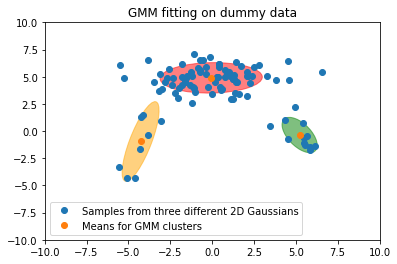

In [23]:
# np.random.seed(42)

means = np.array([
         [0.0, 5.0],
         [5.0, 0.0],
         [-4.0, -1.0],
        ])
          
covs = np.array([
        [[5.0, 0.0],[0.0, 1.0]],
        [[1.0, -1.0],[-1.0, 3.0]],
        [[1.0, 2.0],[2.0, 6.0]]
       ])

N = 100
D = means.shape[1]
K = means.shape[0]

data = np.ndarray([N, D])
# TODO: could convert to func to apply_along_axis
for i in range(N):
#     j = np.random.randint(0, K)
    j = np.random.choice([0, 1, 2], p=[0.8, 0.1, 0.1])
    data[i] = np.random.multivariate_normal(means[j], covs[j])
    
from gmm import GMM
gmm = GMM()
ll, gamma = gmm.fit(data, 3)
pred_means, pred_covs = gmm.mu, gmm.Sigma 

x, y = np.hsplit(data, 2)
px, py = np.hsplit(pred_means, 2)


p1 = plt.plot(x, y,'o', label='Samples from three different 2D Gaussians')[0]
p2 = plt.plot(px, py,'o', label='Means for GMM clusters')[0]
plt.axis([-10, 10, -10, 10])
ax = plt.gca()
ells = make_ellipses(pred_means, pred_covs, ax)
ells = [p1, p2]
plt.legend(ells, [thing.get_label() for thing in ells])
plt.title('GMM fitting on dummy data')
# plt.legend()
# ax.legend()
plt.savefig('gmm_fit.png')
plt.show()

In [24]:
test_data.shape

(10, 2)

In [29]:
test_data = np.random.multivariate_normal(means[0], covs[0], size=10)
gmm.predict(test_data)

(4.8269709819907307, array([[  4.97213236, -23.72791072],
        [  0.14873622,   1.33463423]]), 1, 1)

array([[ 0.52907866,  5.93712587],
       [-3.19332861,  5.17352365],
       [-1.51218909,  5.21626984],
       [-0.9065019 ,  5.55694914],
       [-2.69267513,  4.33648869],
       [-2.99672925,  4.95866319],
       [ 1.1408998 ,  5.79383934],
       [-3.11925205,  4.54695296],
       [-1.43791268,  4.01680107],
       [ 0.40734835,  3.99409904]])

In [19]:
np.sum(np.array([1.0, 3.0, 6.0]), axis=0)

10.0

In [17]:
np.sum(gamma, 0) / np.sum(gamma)

array([0.07777775, 0.76284029, 0.15938196])

In [ ]:
ugmm.mu

In [ ]:
gmm.weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
clf.fit(data)

# display predicted scores by the model as a contour plot
x = np.linspace(-10., 10.)
y = np.linspace(-10., 10.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(data[:, 0], data[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


In [ ]:
clf.predict(data[:7])

In [ ]:
gmm.mu

# Scratch work

In [ ]:
weight_update

In [ ]:
means

In [ ]:
covs

In [ ]:
gmm.fit(data,K)

In [ ]:
weigh_update, mu_update, Sigma_update = gmm.fit(data, K)

In [ ]:
Sigma_update

In [ ]:
weigh_update, mu_update, Sigma_update = gmm.fit(data, K)

In [ ]:
Sigma_update[:, np.arange(D), np.arange(D)] *= n_inv

In [ ]:
Sigma_update

In [ ]:
gmm.fit(data, K)

In [ ]:
Sigma_update.shape

In [ ]:
gmm = GMM()
ll = gmm.fit(data, 3)

In [ ]:
means

In [ ]:
gmm.mu

In [ ]:
covs

In [ ]:
gmm.Sigma

In [1001]:
ll

-485.27351304639774

In [976]:
mu_update[j]

array([-1.61453075,  4.13170679])

In [986]:
diff.dot(diff.T)

49.26349335902119

In [988]:
Sigma_update = np.zeros([K, D, D])

for j in range(K):
    for i in range(N):
        diff = (data[i] - mu_update[j])[np.newaxis, :]
        Sigma_update[j, :, :] += gamma[i][j]*(diff.T.dot(diff))

In [989]:
Sigma_update

array([[[   9.95924362,    3.33348541],
        [   3.33348541,   12.40311268]],

       [[ 197.9181388 ,  280.95201258],
        [ 280.95201258,  620.92221878]],

       [[ 162.36170266,   18.92896659],
        [  18.92896659,  156.23164975]]])

In [686]:
np.dot(gamma.T, np.dot(diff, diff.T)).shape

(3, 100)

In [965]:
np.dot(gamma.T, diff)

ValueError: shapes (3,100) and (1,2) not aligned: 100 (dim 1) != 1 (dim 0)

In [687]:
n_inv

array([[ 0.02562745],
       [ 0.0286697 ],
       [ 0.03831518]])

In [688]:
np.dot(diff, diff.T).shape

(100, 100)

In [692]:
Sigma_update[j, :, :] = (n_inv * np.dot(gamma.T, np.dot(diff, diff.T))).shape

In [707]:
data.shape

(100, 2)

In [708]:
mean.shape

(2,)

In [700]:
diff.shape

(100, 2)

In [701]:
gamma.shape

(100, 3)

In [ ]:
Sigma_update[j, :]

In [713]:
np.dot(gamma.T, diff)

array([[  -9.65482079,   24.62989168],
       [-205.20122489,  176.85873824],
       [-213.86815263,  -18.35245305]])

In [699]:
Sigma_update[0, :, :]

array([[ 0.,  0.],
       [ 0.,  0.]])

In [703]:
Sigma_update = np.zeros([K, D, D])
for j in range(K):
    
    diff = data - mu_update[j]
    print((n_inv * np.dot(gamma.T, np.dot(diff, diff.T))).shape)
    Sigma_update[j, :, :] = np.dot(gamma.T, np.dot(diff, diff.T))


(3, 100)


ValueError: could not broadcast input array from shape (3,100) into shape (2,2)

In [714]:
Sigma_update = np.zeros([K, D, D])
for j in range(K):
    for i in range(N):
        diff = data[i] - mu_update[j]
        Sigma_update[j, :, :] += gamma[i][j]*(diff.T.dot(diff))


In [643]:
gamma.shape

(100, 3)

In [644]:
data.shape

(100, 2)

In [642]:
gamma, n = gmm.fit(data, K)

n

array([ 43.36277483,  33.35210234,  23.28512283])

In [649]:
gamma.shape

(100, 3)

In [650]:
data.shape

(100, 2)

In [651]:
means.shape

(3, 2)

In [659]:
np.dot(gamma.T, data) / n[:, np.newaxis]

array([[ 4.85237497, -0.08285244],
       [-1.07754517,  4.65192766],
       [-4.10972794, -1.43901082]])

In [660]:
1/n[:, np.newaxis] * np.dot(gamma.T, data)

array([[ 4.85237497, -0.08285244],
       [-1.07754517,  4.65192766],
       [-4.10972794, -1.43901082]])

In [ ]:
np.random.cho

In [230]:
idxs = np.random.choice(np.arange(N), size=K, replace=False)
cluster_means = data[idxs]

In [231]:
cluster_means

array([[-1.88594428,  4.48667459],
       [-3.0714901 , -0.26545886],
       [ 6.338028  , -3.28331309]])

In [235]:
d-cluster_means

array([[ 1.64625015,  0.02710812],
       [ 2.83179597,  4.77924158],
       [-6.57772213,  7.7970958 ]])

In [256]:
clusters = np.ndarray(data.shape[0], dtype=np.int8)
for i, d in enumerate(data):
    clusters[i] = np.argmin(np.linalg.norm(d-cluster_means, axis=1))

In [262]:
find_closest_mean = lambda d: np.argmin(np.linalg.norm(d-cluster_means, axis=1))
clusters = np.apply_along_axis(find_closest_mean, 1, data)
clusters

array([1, 0, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0,
       1, 2, 1, 0, 0, 0, 1, 2, 0, 2, 1, 2, 1, 1, 2, 0, 2, 1, 0, 0, 1, 2, 1,
       0, 2, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 2, 2,
       2, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2,
       2, 2, 2, 2, 0, 0, 0, 0])

In [263]:

for k in K:
    data[clusters == k]

array([[-2.67837659,  7.14165843],
       [ 3.26997689,  6.53871497],
       [-3.85703353,  4.43771247],
       [ 0.27329036,  4.48456434],
       [-0.65606044,  4.97016143],
       [-1.34306894,  4.70830625],
       [ 1.65126147,  5.17136828],
       [ 4.10214328,  4.30958824],
       [ 0.76835385,  3.23695984],
       [-1.88594428,  4.48667459],
       [ 1.30166614,  5.88774846],
       [-0.3974211 ,  4.58961669],
       [ 1.81686297,  6.35624003],
       [-2.79947062,  4.18752033],
       [-2.17885639,  5.54815167],
       [ 0.5749308 ,  5.3145129 ],
       [ 1.90048159,  3.68867577],
       [ 0.66214507,  5.26105527],
       [-1.48192792,  4.85352719],
       [-0.1439537 ,  5.34490234],
       [ 3.14213459,  6.39232575],
       [-2.21490656,  4.43370227],
       [-0.93122474,  5.85750325],
       [-3.82486042,  5.11897849],
       [ 0.58111559,  5.78182287],
       [ 2.15738205,  3.93516885],
       [-1.5205815 ,  5.2322537 ],
       [-2.97413603,  4.97471237],
       [-2.42831875,

In [599]:
print(means)
print(covs)

[[ 0.  5.]
 [ 5.  0.]
 [-4. -1.]]
[[[ 5.  0.]
  [ 0.  1.]]

 [[ 1. -1.]
  [-1.  3.]]

 [[ 1.  2.]
  [ 2.  6.]]]


In [614]:
from scipy.stats import multivariate_normal
var = multivariate_normal(means[0], covs[0])
var.pdf([0, 5])

0.071176254341717718